In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import tqdm.notebook as tqdm

from pathlib import Path

%matplotlib inline


import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D

In [2]:
DATA_DIR_PATH = "../data/bengali_AI_handwritten_grapheme_classification"

IMG_HEIGHT = 137
IMG_WIDTH = 236

ROOT_CLASSES_NUM = 168
CONSONANT_CLASSES_NUM = 7
VOWEL_CLASSES_NUM = 11

In [3]:
original_train_df = pd.read_csv("{}/train.csv".format(DATA_DIR_PATH))
test_df = pd.read_csv("{}/test.csv".format(DATA_DIR_PATH))
class_map_df = pd.read_csv("{}/class_map.csv".format(DATA_DIR_PATH))
sample_submission_df = pd.read_csv("{}/sample_submission.csv".format(DATA_DIR_PATH))

In [4]:
sample_submission_df

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0
5,Test_1_vowel_diacritic,0
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,0
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0


In [5]:
class_map_df

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই
...,...,...,...
181,consonant_diacritic,2,র্
182,consonant_diacritic,3,র্য
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র


In [6]:
original_train_df

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


In [7]:
test_df

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root
5,Test_1_vowel_diacritic,Test_1,vowel_diacritic
6,Test_2_consonant_diacritic,Test_2,consonant_diacritic
7,Test_2_grapheme_root,Test_2,grapheme_root
8,Test_2_vowel_diacritic,Test_2,vowel_diacritic
9,Test_3_consonant_diacritic,Test_3,consonant_diacritic


In [8]:
def reshape_img(img_data):
    if isinstance(img_data, pd.Series):
        img_data = img_data.to_numpy()
    
    return img_data.reshape(IMG_HEIGHT, IMG_WIDTH)

In [9]:
def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [10]:
original_train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [11]:
CENTERED_IMAGE_PATH = "../data/bengali_centered"
PREPROCESSED_TRIAN_DATA_CSV_NAME = "new_train_data.csv"

In [12]:
def update_df_with_image_path(df: pd.DataFrame, dataset_name_list: list):
    image_path_list = list()

    for dataset_name in dataset_name_list:
        image_path_data_list = list()
        centered_image_dataset_path = os.path.join(CENTERED_IMAGE_PATH, dataset_name)

        for file in sorted(os.listdir(centered_image_dataset_path)):
            image_id, ext = os.path.splitext(file)

            if ext != ".jpg":
                continue

            idx = int(image_id.split("_")[-1])
            path_data = (idx, image_id, os.path.join(centered_image_dataset_path, file))

            image_path_data_list.append(path_data)

        image_path_data_list = sorted(image_path_data_list, key=lambda path_data: path_data[0])
        image_path_list_in_dataset = list(list(zip(*image_path_data_list))[2])
        image_path_list += image_path_list_in_dataset

    df['preprocessed_image_path'] = image_path_list

In [13]:
# update_df_with_image_path(df=original_train_df, dataset_name_list=["dataset_1", "dataset_2", "dataset_3", "dataset_4"])
# original_train_df.to_csv(os.path.join(CENTERED_IMAGE_PATH, PREPROCESSED_TRIAN_DATA_CSV_NAME), mode='w', index=False)

preprocessed_train_df = pd.read_csv(os.path.join(CENTERED_IMAGE_PATH, PREPROCESSED_TRIAN_DATA_CSV_NAME))

In [14]:
preprocessed_train_df.tail()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,preprocessed_image_path
200835,Train_200835,22,7,2,র্খে,../data/bengali_centered/dataset_4/Train_20083...
200836,Train_200836,65,9,0,ত্তো,../data/bengali_centered/dataset_4/Train_20083...
200837,Train_200837,2,1,4,অ্যা,../data/bengali_centered/dataset_4/Train_20083...
200838,Train_200838,152,9,0,স্নো,../data/bengali_centered/dataset_4/Train_20083...
200839,Train_200839,127,2,0,ল্টি,../data/bengali_centered/dataset_4/Train_20083...


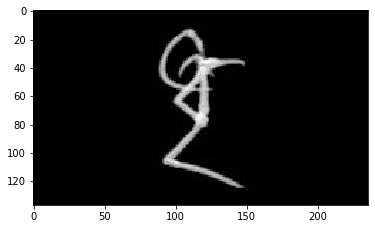

In [15]:
img = cv2.imread(preprocessed_train_df['preprocessed_image_path'][2700])
plt.imshow(img, cmap='gray')
plt.show()

In [16]:
ROOT_CLASSES_NUM = 168
CONSONANT_CLASSES_NUM = 7
VOWEL_CLASSES_NUM = 11

In [17]:
# from sklearn.model_selection import train_test_split

In [18]:
def get_len_train_test_split(full_len: int, test_ratio: float) -> tuple:
    test_len = int(full_len * test_ratio)
    train_len = full_len - test_len
    return train_len, test_len

In [19]:
def get_len_dataset(dataset) -> int:
    count = 0
    for data in dataset:
        count += 1
    
    return count

In [20]:
path_list = preprocessed_train_df['preprocessed_image_path']

root_list = preprocessed_train_df['grapheme_root']
consonant_list = preprocessed_train_df['consonant_diacritic']
vowel_list = preprocessed_train_df['vowel_diacritic']

batch_size = 256
epochs = 10

In [21]:
len_train, len_test_full = get_len_train_test_split(full_len=len(path_list), test_ratio=0.3)
len_val, len_test = get_len_train_test_split(full_len=len_test_full, test_ratio=0.7)

print(f"Train size : {len_train}, Val size : {len_val}, Test size : {len_test}")

Train size : 140588, Val size : 18076, Test size : 42176


In [22]:
# dataset = tf.data.Dataset.from_tensor_slices({
#     "path_list": path_list,
#     "root_list": root_list,
#     "consonant_list": consonant_list,
#     "vowel_list": vowel_list
# })
dataset = tf.data.Dataset.from_tensor_slices((path_list, root_list, consonant_list, vowel_list))
dataset = dataset.shuffle(len(path_list))

In [23]:
train_dataset = dataset.take(len_train)
test_dataset = dataset.skip(len_train)
val_dataset = test_dataset.take(len_val)
test_dataset = test_dataset.skip(len_val)

#print(f"Train size : {get_len_dataset(train_dataset)}, Val size : {get_len_dataset(val_dataset)}, Test size : {get_len_dataset(test_dataset)}")
# Train size : 140588, Val size : 18076, Test size : 42176

In [57]:
del model

In [58]:
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name='img')


m = Conv2D(32, 3, padding='same', activation='relu')(inputs)
m = BatchNormalization(momentum=0.15)(m)
m = MaxPool2D(pool_size=(2, 2))(m)
m = Dropout(rate=0.3)(m)

m = Conv2D(64, 3, padding='same', activation='relu')(m)
m = BatchNormalization(momentum=0.15)(m)
m = MaxPool2D(pool_size=(2, 2))(m)
m = Dropout(rate=0.3)(m)

m = Conv2D(128, 3, padding='same', activation='relu')(m)
m = BatchNormalization(momentum=0.15)(m)
m = MaxPool2D(pool_size=(2, 2))(m)
m = Dropout(rate=0.3)(m)

m = Conv2D(256, 3, padding='same', activation='relu')(m)
m = BatchNormalization(momentum=0.15)(m)
m = MaxPool2D(pool_size=(2, 2))(m)
m = Dropout(rate=0.3)(m)


m = Conv2D(512, 3, padding='same', activation='relu')(m)
m = BatchNormalization(momentum=0.15)(m)
m = MaxPool2D(pool_size=(2, 2))(m)
m = Dropout(rate=0.3)(m)

m = Flatten()(m)

m = Dense(256, activation='relu')(m)
m = Dropout(rate=0.3)(m)
m = Dense(128, activation='relu')(m)
m = Dropout(rate=0.3)(m)

root = Dense(ROOT_CLASSES_NUM, activation='softmax', name='root')(m)
consonant = Dense(CONSONANT_CLASSES_NUM, activation='softmax', name='consonant')(m)
vowel = Dense(VOWEL_CLASSES_NUM, activation='softmax', name='vowel')(m)

In [59]:
model = tf.keras.Model(inputs=inputs, outputs=[root, consonant, vowel])

In [60]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 137, 236, 1) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 137, 236, 32) 320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 137, 236, 32) 128         conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 68, 118, 32)  0           batch_normalization_15[0][0]     
____________________________________________________________________________________________

In [61]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [62]:
# ROOT_CLASSES_NUM = 168
# CONSONANT_CLASSES_NUM = 7
# VOWEL_CLASSES_NUM = 11

In [63]:
def read_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

def load_img(path_list):
    return tf.map_fn(read_img, path_list, dtype=tf.float32)

In [ ]:
history_list = list()

# img_batch = None  # 이 부분 수정할 것. 비효율적임

# for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(len(path_list)):
# # for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(10240).take(1):
#     if img_batch is None:
#         time_st = time.time()
#         img_batch = tf.map_fn(read_img, path_batch, dtype=tf.float32)
#         time_ed = time.time()
#         print("Elapsed time for loading image data : {}".format(time_ed - time_st))

#     history = model.fit(
#         x={'img': img_batch},
#         y={'root': root_batch, 'consonant': consonant_batch, 'vowel': vowel_batch},
#         batch_size=128,  # 256 은 GPU 메모리 부족
#         epochs=2
#     )

#     history_list.append(history)

for epoch in range(100):
    
    print("== Epoch : {} ==\n".format(epoch))
    for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(10240):
#     for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(1024).take(2):
        time_st = time.time()
        img_batch = tf.map_fn(read_img, path_batch, dtype=tf.float32)
        time_ed = time.time()
        print("Elapsed time for loading image data : {}".format(time_ed - time_st))
        
        history = model.fit(
            x={'img': img_batch},
            y={'root': root_batch, 'consonant': consonant_batch, 'vowel': vowel_batch},
            batch_size=128  # 256 은 GPU 메모리 부족
        )
        
        # Appending history
        history_list.append((epoch, history))
    
    print(f"Epoch {epoch} - ")

== Epoch : 0 ==

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/control_flow_ops.py", line 2757, in while_loop
    return result  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/control_flow_ops.py", line 2705, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/map_fn.py", line 261, in compute
    return (i + 1, tas)  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/map_fn.py", line 260, in <listcomp>
    tas = [ta.write(i, value) for (ta, value) in zip(tas, flat_fn_values)]  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/tf_should_use.py", line 237, in wrapped
    error_in

10240/10240 [==============================] - 16s 2ms/sample - loss: 8580937593651.2002 - root_loss: 8565329756160.0000 - consonant_loss: 2248635392.0000 - vowel_loss: 13359755264.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1428 - vowel_accuracy: 0.0359
Elapsed time for loading image data : 28.67405414581299
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 9824134509363.2012 - root_loss: 9806213545984.0000 - consonant_loss: 2552396544.0000 - vowel_loss: 15366386688.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1425 - vowel_accuracy: 0.0345
Elapsed time for loading image data : 28.872474431991577
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 11222273399193.5996 - root_loss: 11201813676032.0000 - consonant_loss: 2925743872.0000 - vowel_loss: 17533038592.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0346
Elapsed time for loading image data

10240/10240 [==============================] - 16s 2ms/sample - loss: 60604433249075.1953 - root_loss: 60500171816960.0000 - consonant_loss: 14675163136.0000 - vowel_loss: 89589121024.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1440 - vowel_accuracy: 0.0386
Elapsed time for loading image data : 9.82439637184143
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 63492905762816.0000 - root_loss: 63382388473856.0000 - consonant_loss: 15652526080.0000 - vowel_loss: 94852841472.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1474 - vowel_accuracy: 0.0407
Elapsed time for loading image data : 9.216883659362793
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 67091448882790.3984 - root_loss: 66972754640896.0000 - consonant_loss: 16544897024.0000 - vowel_loss: 102134423552.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1450 - vowel_accuracy: 0.0384
Elapsed time for loading imag

10240/10240 [==============================] - 16s 2ms/sample - loss: 168505641638297.5938 - root_loss: 168218836598784.0000 - consonant_loss: 41703251968.0000 - vowel_loss: 245095759872.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1424 - vowel_accuracy: 0.0417
Elapsed time for loading image data : 7.33447265625
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 173292805265817.5938 - root_loss: 172995779756032.0000 - consonant_loss: 42091896832.0000 - vowel_loss: 254927224832.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1497 - vowel_accuracy: 0.0411
Elapsed time for loading image data : 7.545804977416992
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 180248318364876.7812 - root_loss: 179941782061056.0000 - consonant_loss: 42636427264.0000 - vowel_loss: 263939031040.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0449
Elapsed time for loading

10240/10240 [==============================] - 16s 2ms/sample - loss: 337702255853568.0000 - root_loss: 337152315490304.0000 - consonant_loss: 77248626688.0000 - vowel_loss: 472779161600.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1494 - vowel_accuracy: 0.0429
Elapsed time for loading image data : 7.049498558044434
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 349096095671910.4375 - root_loss: 348525254672384.0000 - consonant_loss: 80641212416.0000 - vowel_loss: 490220191744.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1446 - vowel_accuracy: 0.0454
Elapsed time for loading image data : 6.822618007659912
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 358513013633843.1875 - root_loss: 357919958761472.0000 - consonant_loss: 83008053248.0000 - vowel_loss: 510063443968.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1473 - vowel_accuracy: 0.0483
Elapsed time for loa

10240/10240 [==============================] - 16s 2ms/sample - loss: 583233379395174.3750 - root_loss: 582307639459840.0000 - consonant_loss: 126152237056.0000 - vowel_loss: 799478579200.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1510 - vowel_accuracy: 0.0476
Elapsed time for loading image data : 6.5135462284088135
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 588528949919744.0000 - root_loss: 587553807794176.0000 - consonant_loss: 133908881408.0000 - vowel_loss: 841286680576.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1459 - vowel_accuracy: 0.0475
Elapsed time for loading image data : 6.73623514175415
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 605798594825420.8750 - root_loss: 604815751118848.0000 - consonant_loss: 139257970688.0000 - vowel_loss: 843642961920.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1490 - vowel_accuracy: 0.0439
Elapsed time for 

10240/10240 [==============================] - 16s 2ms/sample - loss: 894481754750976.0000 - root_loss: 893045167882240.0000 - consonant_loss: 200828076032.0000 - vowel_loss: 1235764903936.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1505 - vowel_accuracy: 0.0488
Elapsed time for loading image data : 6.903069734573364
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 910916049489100.8750 - root_loss: 909461472411648.0000 - consonant_loss: 202799185920.0000 - vowel_loss: 1251670097920.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1481 - vowel_accuracy: 0.0488
Elapsed time for loading image data : 7.03987717628479
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 934455110166118.3750 - root_loss: 932951722295296.0000 - consonant_loss: 206802321408.0000 - vowel_loss: 1296431841280.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1457 - vowel_accuracy: 0.0491
Elapsed time fo

Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 1320962057515827.2500 - root_loss: 1318898288820224.0000 - consonant_loss: 284123758592.0000 - vowel_loss: 1779787497472.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1460 - vowel_accuracy: 0.0508
Elapsed time for loading image data : 6.845414638519287
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 1332175576236032.0000 - root_loss: 1330101845229568.0000 - consonant_loss: 292257333248.0000 - vowel_loss: 1781386575872.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1480 - vowel_accuracy: 0.0490
Elapsed time for loading image data : 6.614776849746704
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 1350070559152537.7500 - root_loss: 1347947031691264.0000 - consonant_loss: 294613811200.0000 - vowel_loss: 1829274124288.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1448 - vowel_ac

Train on 7468 samples
7468/7468 [==============================] - 11s 1ms/sample - loss: 1823213928074160.5000 - root_loss: 1821793593589760.0000 - consonant_loss: 396241403904.0000 - vowel_loss: 2390813835264.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1501 - vowel_accuracy: 0.0479
Epoch 12 - 
== Epoch : 13 ==

Elapsed time for loading image data : 6.7771666049957275
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 1822595032809472.0000 - root_loss: 1819731740852224.0000 - consonant_loss: 389120000000.0000 - vowel_loss: 2474057138176.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1460 - vowel_accuracy: 0.0530
Elapsed time for loading image data : 6.824624061584473
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 1846066826077798.2500 - root_loss: 1843211655970816.0000 - consonant_loss: 412967043072.0000 - vowel_loss: 2442226827264.0000 - root_accuracy: 0.0000e+00 - consonant

10240/10240 [==============================] - 16s 2ms/sample - loss: 2387764836722278.5000 - root_loss: 2384072726806528.0000 - consonant_loss: 521587720192.0000 - vowel_loss: 3169356611584.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1479 - vowel_accuracy: 0.0544
Elapsed time for loading image data : 6.490936994552612
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 2411761144483020.5000 - root_loss: 2408054750445568.0000 - consonant_loss: 515240525824.0000 - vowel_loss: 3191243538432.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1464 - vowel_accuracy: 0.0498
Elapsed time for loading image data : 7.130474805831909
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 2425934221148160.0000 - root_loss: 2422189487816704.0000 - consonant_loss: 528179593216.0000 - vowel_loss: 3216821190656.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1508 - vowel_accuracy: 0.0531
Elapsed 

Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 3103886076280832.0000 - root_loss: 3099130020757504.0000 - consonant_loss: 672582991872.0000 - vowel_loss: 4083287588864.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1426 - vowel_accuracy: 0.0553
Elapsed time for loading image data : 6.64271879196167
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 3140254711781785.5000 - root_loss: 3135482892386304.0000 - consonant_loss: 658903007232.0000 - vowel_loss: 4112634085376.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1494 - vowel_accuracy: 0.0515
Elapsed time for loading image data : 6.618061542510986
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 3134325888594739.5000 - root_loss: 3129501613555712.0000 - consonant_loss: 674287845376.0000 - vowel_loss: 4149561786368.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1463 - vowel_acc

Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 3971381960114176.0000 - root_loss: 3965387074961408.0000 - consonant_loss: 825431293952.0000 - vowel_loss: 5170032803840.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1440 - vowel_accuracy: 0.0549
Elapsed time for loading image data : 6.673672437667847
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 3987780544548044.5000 - root_loss: 3981811029901312.0000 - consonant_loss: 838236110848.0000 - vowel_loss: 5131182014464.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1473 - vowel_accuracy: 0.0559
Elapsed time for loading image data : 4.836471080780029
Train on 7468 samples
7468/7468 [==============================] - 11s 1ms/sample - loss: 4009841768184794.5000 - root_loss: 4001798197084160.0000 - consonant_loss: 810043113472.0000 - vowel_loss: 5159089340416.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1474 - vowel_accur

10240/10240 [==============================] - 16s 2ms/sample - loss: 4868813715668992.0000 - root_loss: 4861627027423232.0000 - consonant_loss: 1025169162240.0000 - vowel_loss: 6162581291008.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1411 - vowel_accuracy: 0.0575
Elapsed time for loading image data : 6.88311767578125
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 4879523230043341.0000 - root_loss: 4872262977060864.0000 - consonant_loss: 1007321677824.0000 - vowel_loss: 6252862636032.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0544
Elapsed time for loading image data : 6.554373502731323
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 4999174854960743.0000 - root_loss: 4991813391745024.0000 - consonant_loss: 1019091943424.0000 - vowel_loss: 6343032307712.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1400 - vowel_accuracy: 0.0543
Elapse

Elapsed time for loading image data : 6.552380323410034
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 5972706565763891.0000 - root_loss: 5963951321907200.0000 - consonant_loss: 1245147693056.0000 - vowel_loss: 7509498658816.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1443 - vowel_accuracy: 0.0554
Elapsed time for loading image data : 6.639455556869507
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 5975334488480153.0000 - root_loss: 5966489110708224.0000 - consonant_loss: 1210084229120.0000 - vowel_loss: 7636115259392.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1441 - vowel_accuracy: 0.0556
Elapsed time for loading image data : 6.67659592628479
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 6110265697789543.0000 - root_loss: 6101321019031552.0000 - consonant_loss: 1246274256896.0000 - vowel_loss: 7699539427328.0000 - root_ac

10240/10240 [==============================] - 16s 2ms/sample - loss: 7104721975875993.0000 - root_loss: 7094301351739392.0000 - consonant_loss: 1421127581696.0000 - vowel_loss: 9000545419264.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1404 - vowel_accuracy: 0.0599
Elapsed time for loading image data : 7.044533014297485
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 7167546818035712.0000 - root_loss: 7157121690894336.0000 - consonant_loss: 1458441420800.0000 - vowel_loss: 8967195459584.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1458 - vowel_accuracy: 0.0542
Elapsed time for loading image data : 6.991703510284424
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 7322262445228032.0000 - root_loss: 7311650319237120.0000 - consonant_loss: 1482943102976.0000 - vowel_loss: 9130457694208.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1469 - vowel_accuracy: 0.0578
Elaps

10240/10240 [==============================] - 16s 2ms/sample - loss: 8404390098921063.0000 - root_loss: 8392095513444352.0000 - consonant_loss: 1700403740672.0000 - vowel_loss: 10593182416896.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1478 - vowel_accuracy: 0.0582
Elapsed time for loading image data : 6.723076343536377
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 8517156626182963.0000 - root_loss: 8504933967986688.0000 - consonant_loss: 1732736450560.0000 - vowel_loss: 10490841399296.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1459 - vowel_accuracy: 0.0593
Elapsed time for loading image data : 6.524447202682495
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 8609051330373223.0000 - root_loss: 8596545620410368.0000 - consonant_loss: 1738425892864.0000 - vowel_loss: 10765004177408.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1424 - vowel_accuracy: 0.0612
El

10240/10240 [==============================] - 16s 2ms/sample - loss: 9974646758493390.0000 - root_loss: 9960590726397952.0000 - consonant_loss: 1958026543104.0000 - vowel_loss: 12098671214592.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1415 - vowel_accuracy: 0.0666
Elapsed time for loading image data : 6.844324588775635
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 10008346642245222.0000 - root_loss: 9993978728415232.0000 - consonant_loss: 1984135823360.0000 - vowel_loss: 12382864670720.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0578
Elapsed time for loading image data : 7.092540979385376
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 10079171350888448.0000 - root_loss: 10064654562754560.0000 - consonant_loss: 2042487373824.0000 - vowel_loss: 12473966002176.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1464 - vowel_accuracy: 0.0604

10240/10240 [==============================] - 16s 2ms/sample - loss: 11550879489248462.0000 - root_loss: 11534318283259904.0000 - consonant_loss: 2306005008384.0000 - vowel_loss: 14255882502144.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1431 - vowel_accuracy: 0.0620
Elapsed time for loading image data : 6.525640964508057
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 11679247176512306.0000 - root_loss: 11662616472584192.0000 - consonant_loss: 2297755860992.0000 - vowel_loss: 14334652579840.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1467 - vowel_accuracy: 0.0604
Elapsed time for loading image data : 6.619984149932861
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 11675699627478222.0000 - root_loss: 11659127885398016.0000 - consonant_loss: 2292636975104.0000 - vowel_loss: 14277575442432.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1464 - vowel_accuracy: 0.0

10240/10240 [==============================] - 16s 2ms/sample - loss: 13417630491947826.0000 - root_loss: 13398512330866688.0000 - consonant_loss: 2590177492992.0000 - vowel_loss: 16525891207168.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1425 - vowel_accuracy: 0.0665
Elapsed time for loading image data : 5.234477996826172
Train on 7468 samples
7468/7468 [==============================] - 11s 1ms/sample - loss: 13346861950771048.0000 - root_loss: 13341875670876160.0000 - consonant_loss: 2670208483328.0000 - vowel_loss: 16135950958592.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1441 - vowel_accuracy: 0.0588
Epoch 28 - 
== Epoch : 29 ==

Elapsed time for loading image data : 6.588285446166992
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 13516879119672934.0000 - root_loss: 13497714264244224.0000 - consonant_loss: 2704280911872.0000 - vowel_loss: 16461879836672.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0

10240/10240 [==============================] - 16s 2ms/sample - loss: 15401898363112654.0000 - root_loss: 15380169439051776.0000 - consonant_loss: 3076441243648.0000 - vowel_loss: 18651744829440.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0597
Elapsed time for loading image data : 6.997836351394653
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 15285183150292992.0000 - root_loss: 15263274387898368.0000 - consonant_loss: 3010692644864.0000 - vowel_loss: 18897726078976.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1454 - vowel_accuracy: 0.0641
Elapsed time for loading image data : 6.735607385635376
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 15594379389435904.0000 - root_loss: 15572486263406592.0000 - consonant_loss: 2956853772288.0000 - vowel_loss: 18936800215040.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0

10240/10240 [==============================] - 16s 2ms/sample - loss: 17231532567140762.0000 - root_loss: 17206669779927040.0000 - consonant_loss: 3274129539072.0000 - vowel_loss: 21590699933696.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1408 - vowel_accuracy: 0.0640
Elapsed time for loading image data : 6.942223310470581
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 17538323423271322.0000 - root_loss: 17514172258451456.0000 - consonant_loss: 3456846004224.0000 - vowel_loss: 20696751144960.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1448 - vowel_accuracy: 0.0623
Elapsed time for loading image data : 7.1411333084106445
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 17624941250111078.0000 - root_loss: 17600025433473024.0000 - consonant_loss: 3418989789184.0000 - vowel_loss: 21499062779904.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.

10240/10240 [==============================] - 16s 2ms/sample - loss: 19676077238937188.0000 - root_loss: 19648532633878528.0000 - consonant_loss: 3815859552256.0000 - vowel_loss: 23730086477824.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1411 - vowel_accuracy: 0.0660
Elapsed time for loading image data : 6.648080348968506
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 19873183609493916.0000 - root_loss: 19845267905839104.0000 - consonant_loss: 3781496930304.0000 - vowel_loss: 24131177283584.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1448 - vowel_accuracy: 0.0686
Elapsed time for loading image data : 6.717305421829224
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 19918380744887500.0000 - root_loss: 19890740872085504.0000 - consonant_loss: 3884886786048.0000 - vowel_loss: 23752796536832.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0

10240/10240 [==============================] - 16s 2ms/sample - loss: 22228961494407580.0000 - root_loss: 22198310836109312.0000 - consonant_loss: 4040357838848.0000 - vowel_loss: 26611843858432.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1436 - vowel_accuracy: 0.0645
Elapsed time for loading image data : 6.713103771209717
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 22221159283661212.0000 - root_loss: 22190150398246912.0000 - consonant_loss: 4126611603456.0000 - vowel_loss: 26891213864960.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1462 - vowel_accuracy: 0.0632
Elapsed time for loading image data : 6.615951061248779
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 22405486690382644.0000 - root_loss: 22374086667665408.0000 - consonant_loss: 4169402941440.0000 - vowel_loss: 27230524669952.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1471 - vowel_accuracy: 0.0

10240/10240 [==============================] - 16s 2ms/sample - loss: 24827081835256220.0000 - root_loss: 24792168287698944.0000 - consonant_loss: 4691850166272.0000 - vowel_loss: 30216346927104.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1434 - vowel_accuracy: 0.0656
Elapsed time for loading image data : 6.667139053344727
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 24975819693411532.0000 - root_loss: 24941008231858176.0000 - consonant_loss: 4737745813504.0000 - vowel_loss: 30069271560192.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1478 - vowel_accuracy: 0.0609
Elapsed time for loading image data : 6.615686655044556
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 25150693984488652.0000 - root_loss: 25115877825314816.0000 - consonant_loss: 4796547334144.0000 - vowel_loss: 30013042720768.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1402 - vowel_accuracy: 0.0

10240/10240 [==============================] - 16s 2ms/sample - loss: 27768091373364836.0000 - root_loss: 27729404079636480.0000 - consonant_loss: 5144394596352.0000 - vowel_loss: 33541385617408.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1443 - vowel_accuracy: 0.0651
Elapsed time for loading image data : 6.499552488327026
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 28020351633562012.0000 - root_loss: 27982420603043840.0000 - consonant_loss: 5148993126400.0000 - vowel_loss: 32781813940224.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1447 - vowel_accuracy: 0.0689
Elapsed time for loading image data : 6.509167432785034
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 28084107255532748.0000 - root_loss: 28045419183341568.0000 - consonant_loss: 5324603916288.0000 - vowel_loss: 33362588729344.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1431 - vowel_accuracy: 0.0

10240/10240 [==============================] - 16s 2ms/sample - loss: 30921784792868452.0000 - root_loss: 30878935810048000.0000 - consonant_loss: 5679669575680.0000 - vowel_loss: 37172975501312.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1416 - vowel_accuracy: 0.0669
Elapsed time for loading image data : 5.24570369720459
Train on 7468 samples
7468/7468 [==============================] - 11s 1ms/sample - loss: 30889041528776968.0000 - root_loss: 30887349650980864.0000 - consonant_loss: 5764585881600.0000 - vowel_loss: 37091278848000.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1466 - vowel_accuracy: 0.0672
Epoch 39 - 
== Epoch : 40 ==

Elapsed time for loading image data : 7.094656944274902
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 30792688142280292.0000 - root_loss: 30750185575415808.0000 - consonant_loss: 5952085426176.0000 - vowel_loss: 36554454073344.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.

10240/10240 [==============================] - 16s 2ms/sample - loss: 34142032864529612.0000 - root_loss: 34095466882793472.0000 - consonant_loss: 6309833867264.0000 - vowel_loss: 40256871071744.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1426 - vowel_accuracy: 0.0695
Elapsed time for loading image data : 6.608530759811401
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 34239220834054964.0000 - root_loss: 34192780104302592.0000 - consonant_loss: 6315043717120.0000 - vowel_loss: 40124163293184.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1422 - vowel_accuracy: 0.0690
Elapsed time for loading image data : 6.646730661392212
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 34274315924511132.0000 - root_loss: 34227665976164352.0000 - consonant_loss: 6196034535424.0000 - vowel_loss: 40454749945856.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1493 - vowel_accuracy: 0.0

10240/10240 [==============================] - 16s 2ms/sample - loss: 37447188681536312.0000 - root_loss: 37395824979738624.0000 - consonant_loss: 6779493154816.0000 - vowel_loss: 44580279943168.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1462 - vowel_accuracy: 0.0699
Elapsed time for loading image data : 6.583762168884277
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 37602371030745088.0000 - root_loss: 37550830349451264.0000 - consonant_loss: 6976036143104.0000 - vowel_loss: 44559698493440.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1434 - vowel_accuracy: 0.0687
Elapsed time for loading image data : 6.962736368179321
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 37913027357442048.0000 - root_loss: 37861000002666496.0000 - consonant_loss: 7004533293056.0000 - vowel_loss: 45021600415744.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1450 - vowel_accuracy: 0.0

10240/10240 [==============================] - 15s 2ms/sample - loss: 41477579361746944.0000 - root_loss: 41422296690196480.0000 - consonant_loss: 7570975621120.0000 - vowel_loss: 47710782619648.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1444 - vowel_accuracy: 0.0702
Elapsed time for loading image data : 6.4238317012786865
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 41502455866012472.0000 - root_loss: 41446232542937088.0000 - consonant_loss: 7543805444096.0000 - vowel_loss: 48669122363392.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1492 - vowel_accuracy: 0.0668
Elapsed time for loading image data : 6.703646183013916
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 41452796380394296.0000 - root_loss: 41395745202372608.0000 - consonant_loss: 7635411664896.0000 - vowel_loss: 49409836449792.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1438 - vowel_accuracy: 0.

10240/10240 [==============================] - 16s 2ms/sample - loss: 45408598108405760.0000 - root_loss: 45347325568090112.0000 - consonant_loss: 8051156844544.0000 - vowel_loss: 53214657380352.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1457 - vowel_accuracy: 0.0667
Elapsed time for loading image data : 6.953230857849121
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 45236487011382072.0000 - root_loss: 45173967803121664.0000 - consonant_loss: 8312013193216.0000 - vowel_loss: 54208250249216.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1410 - vowel_accuracy: 0.0736
Elapsed time for loading image data : 6.594616413116455
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 45373623008598424.0000 - root_loss: 45311776123781120.0000 - consonant_loss: 8298989879296.0000 - vowel_loss: 53551791341568.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1437 - vowel_accuracy: 0.0

10240/10240 [==============================] - 16s 2ms/sample - loss: 49928258175421640.0000 - root_loss: 49860992598802432.0000 - consonant_loss: 8754222333952.0000 - vowel_loss: 58499325231104.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0693
Elapsed time for loading image data : 6.975975513458252
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 49145005712867328.0000 - root_loss: 49078221924204544.0000 - consonant_loss: 9153818918912.0000 - vowel_loss: 57635265052672.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1396 - vowel_accuracy: 0.0706
Elapsed time for loading image data : 6.59050178527832
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 49658667104783560.0000 - root_loss: 49591831293329408.0000 - consonant_loss: 8882434867200.0000 - vowel_loss: 57958796886016.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1467 - vowel_accuracy: 0.07

10240/10240 [==============================] - 16s 2ms/sample - loss: 54569907017429816.0000 - root_loss: 54496215793926144.0000 - consonant_loss: 9706909204480.0000 - vowel_loss: 63978596204544.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1452 - vowel_accuracy: 0.0757
Elapsed time for loading image data : 6.561030149459839
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 54642522351625832.0000 - root_loss: 54569487935995904.0000 - consonant_loss: 9818474545152.0000 - vowel_loss: 63214079442944.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1428 - vowel_accuracy: 0.0674
Elapsed time for loading image data : 7.159448862075806
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 54316161047514312.0000 - root_loss: 54242237197844480.0000 - consonant_loss: 9606450380800.0000 - vowel_loss: 64308604043264.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1420 - vowel_accuracy: 0.0

10240/10240 [==============================] - 16s 2ms/sample - loss: 59007791712436224.0000 - root_loss: 58928544733986816.0000 - consonant_loss: 10297559482368.0000 - vowel_loss: 68955699937280.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1427 - vowel_accuracy: 0.0709
Elapsed time for loading image data : 4.897043704986572
Train on 7468 samples
7468/7468 [==============================] - 11s 1ms/sample - loss: 58472594454239808.0000 - root_loss: 58446048107954176.0000 - consonant_loss: 10248507097088.0000 - vowel_loss: 68708680597504.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1477 - vowel_accuracy: 0.0720
Epoch 50 - 
== Epoch : 51 ==

Elapsed time for loading image data : 6.654794216156006
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 58966259217622632.0000 - root_loss: 58887094004613120.0000 - consonant_loss: 10277543215104.0000 - vowel_loss: 68888549130240.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy

10240/10240 [==============================] - 16s 2ms/sample - loss: 63326788330402616.0000 - root_loss: 63240756323680256.0000 - consonant_loss: 11074270134272.0000 - vowel_loss: 74956390006784.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1412 - vowel_accuracy: 0.0754
Elapsed time for loading image data : 6.657134056091309
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 63569212068593664.0000 - root_loss: 63483224407408640.0000 - consonant_loss: 11222066921472.0000 - vowel_loss: 74784448708608.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1453 - vowel_accuracy: 0.0719
Elapsed time for loading image data : 7.043102025985718
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 63687781083250688.0000 - root_loss: 63601400432558080.0000 - consonant_loss: 11133229465600.0000 - vowel_loss: 75245528547328.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1450 - vowel_accuracy: 

10240/10240 [==============================] - 16s 2ms/sample - loss: 68618350066715848.0000 - root_loss: 68528698583678976.0000 - consonant_loss: 11944906981376.0000 - vowel_loss: 77712232284160.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0676
Elapsed time for loading image data : 6.561611175537109
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 69677705360886984.0000 - root_loss: 69586909805936640.0000 - consonant_loss: 11741729652736.0000 - vowel_loss: 79056733208576.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1427 - vowel_accuracy: 0.0759
Elapsed time for loading image data : 6.629339694976807
Train on 10240 samples
10240/10240 [==============================] - 16s 2ms/sample - loss: 68733488583619384.0000 - root_loss: 68641316921147392.0000 - consonant_loss: 11973947293696.0000 - vowel_loss: 80205997670400.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1437 - vowel_accuracy: 

10240/10240 [==============================] - 15s 1ms/sample - loss: 67986461378478080.0000 - root_loss: 67893700553867264.0000 - consonant_loss: 11947481235456.0000 - vowel_loss: 80802754854912.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0697
Elapsed time for loading image data : 6.603609323501587
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 68951891536091544.0000 - root_loss: 68860261468995584.0000 - consonant_loss: 12003605217280.0000 - vowel_loss: 79610523942912.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1482 - vowel_accuracy: 0.0733
Elapsed time for loading image data : 6.929404973983765
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 68851567166698296.0000 - root_loss: 68760321874984960.0000 - consonant_loss: 11855122661376.0000 - vowel_loss: 79394668281856.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1392 - vowel_accuracy: 

10240/10240 [==============================] - 15s 1ms/sample - loss: 74555237511200768.0000 - root_loss: 74453893731319808.0000 - consonant_loss: 12925348610048.0000 - vowel_loss: 88448434176000.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1456 - vowel_accuracy: 0.0737
Elapsed time for loading image data : 6.45562744140625
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 74792909673385168.0000 - root_loss: 74692041077948416.0000 - consonant_loss: 13024003883008.0000 - vowel_loss: 87819540234240.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1414 - vowel_accuracy: 0.0687
Elapsed time for loading image data : 7.1162755489349365
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 75236760183688400.0000 - root_loss: 75136982509944832.0000 - consonant_loss: 13275371667456.0000 - vowel_loss: 86503216644096.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1470 - vowel_accuracy: 

10240/10240 [==============================] - 15s 1ms/sample - loss: 81166973410056592.0000 - root_loss: 81061468987981824.0000 - consonant_loss: 13921278754816.0000 - vowel_loss: 91587107356672.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1452 - vowel_accuracy: 0.0708
Elapsed time for loading image data : 6.603476524353027
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 80830237290319056.0000 - root_loss: 80721788614475776.0000 - consonant_loss: 14260841218048.0000 - vowel_loss: 94182265847808.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1445 - vowel_accuracy: 0.0724
Elapsed time for loading image data : 6.595952033996582
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 81568250325473680.0000 - root_loss: 81459363348217856.0000 - consonant_loss: 14241757134848.0000 - vowel_loss: 94626132262912.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1456 - vowel_accuracy: 

10240/10240 [==============================] - 15s 1ms/sample - loss: 87805840778382544.0000 - root_loss: 87690699469750272.0000 - consonant_loss: 15273781362688.0000 - vowel_loss: 99855355609088.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1461 - vowel_accuracy: 0.0745
Elapsed time for loading image data : 6.52714204788208
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 87426475014435632.0000 - root_loss: 87310508964708352.0000 - consonant_loss: 15315641565184.0000 - vowel_loss: 100660192215040.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1431 - vowel_accuracy: 0.0733
Elapsed time for loading image data : 6.847453832626343
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 88111651469289072.0000 - root_loss: 87994791744241664.0000 - consonant_loss: 15316966965248.0000 - vowel_loss: 101548310921216.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1422 - vowel_accuracy:

10240/10240 [==============================] - 15s 1ms/sample - loss: 93205725884868208.0000 - root_loss: 93081682290147328.0000 - consonant_loss: 15870756651008.0000 - vowel_loss: 108196442144768.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1405 - vowel_accuracy: 0.0761
Elapsed time for loading image data : 4.886637210845947
Train on 7468 samples
7468/7468 [==============================] - 11s 1ms/sample - loss: 94108515972041424.0000 - root_loss: 94082444029853696.0000 - consonant_loss: 15648767868928.0000 - vowel_loss: 109625567346688.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1494 - vowel_accuracy: 0.0726
Epoch 61 - 
== Epoch : 62 ==

Elapsed time for loading image data : 6.782592296600342
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 94407905484629616.0000 - root_loss: 94283396959698944.0000 - consonant_loss: 15672209833984.0000 - vowel_loss: 108841802924032.0000 - root_accuracy: 0.0000e+00 - consonant_accur

10240/10240 [==============================] - 15s 1ms/sample - loss: 100275812962612016.0000 - root_loss: 100143948554567680.0000 - consonant_loss: 16999785693184.0000 - vowel_loss: 114882749923328.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1430 - vowel_accuracy: 0.0747
Elapsed time for loading image data : 6.615275621414185
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 99849723430567936.0000 - root_loss: 99716839826784256.0000 - consonant_loss: 17327486664704.0000 - vowel_loss: 115575271456768.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1447 - vowel_accuracy: 0.0748
Elapsed time for loading image data : 6.972697019577026
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 100992184838678128.0000 - root_loss: 100858210205827072.0000 - consonant_loss: 16703880691712.0000 - vowel_loss: 117278293098496.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1396 - vowel_acc

10240/10240 [==============================] - 15s 1ms/sample - loss: 106838440957024656.0000 - root_loss: 106699245469302784.0000 - consonant_loss: 18161118216192.0000 - vowel_loss: 121032404893696.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1435 - vowel_accuracy: 0.0728
Elapsed time for loading image data : 6.4934821128845215
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 107449613836877824.0000 - root_loss: 107307524507566080.0000 - consonant_loss: 17501746364416.0000 - vowel_loss: 124589401178112.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1456 - vowel_accuracy: 0.0767
Elapsed time for loading image data : 6.603515863418579
Train on 10240 samples
10240/10240 [==============================] - 15s 1ms/sample - loss: 108641235548032208.0000 - root_loss: 108498072262148096.0000 - consonant_loss: 17920459538432.0000 - vowel_loss: 125239316971520.0000 - root_accuracy: 0.0000e+00 - consonant_accuracy: 0.1447 - vowel_

In [34]:
history.epoch

NameError: name 'history' is not defined

In [47]:
history

In [37]:
model.

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 137, 236, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'img'},
   'name': 'img',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d_1',
   'inbound_nodes': [[['img', 0, 0, {}]]]},
  {'class_name': 'BatchNormalization',
   'config': {'name': 'batc

In [ ]:
a

In [ ]:
a = [1]

In [265]:
for epoch in range(epochs):
    for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(batch_size).take(1):
        print(path, root, consonant, vowel)
    
    print(f"Epoch {epoch} - ")

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

tf.Tensor(
[b'../data/bengali_centered/dataset_2/Train_54378.jpg'
 b'../data/bengali_centered/dataset_4/Train_162711.jpg'
 b'../data/bengali_centered/dataset_1/Train_33415.jpg'
 b'../data/bengali_centered/dataset_4/Train_180451.jpg'
 b'../data/bengali_centered/dataset_2/Train_79757.jpg'
 b'../data/bengali_centered/dataset_3/Train_136436.jpg'
 b'../data/bengali_centered/dataset_3/Train_130390.jpg'
 b'../data/bengali_centered/dataset_4/Train_163929.jpg'
 b'../data/bengali_centered/dataset_4/Train_150903.jpg'
 b'../data/bengali_centered/dataset_3/Train_122053.jpg'
 b'../data/bengali_centered/dataset_3/Train_104227.jpg'
 b'../data/bengali_centered/dataset_4/Train_192660.jpg'
 b'../data/bengali_centered/dataset_3/Train_128699.jpg'
 b'../data/bengali_centered/dataset_4/Train_178040.jpg'
 b'../data/bengali_centered/dataset_4/Train_154349.jpg'
 b'../data/bengali_centered/dataset_1/Train_28364.jpg'
 b'../data/bengali_centered/dataset_1/Train_42545.jpg'
 b'../data/bengali_centered/dataset_2/Trai

In [126]:
# x_train_path, y_test_path, y_train_root, y_test_root, y_train_consonant, y_test_consonant, y_train_vowl, y_test_vowel = \
#     train_test_split(path_list, root_one_hot_list, consonant_one_hot_list, vowel_one_hot_list, test_size=0.3)

In [127]:
x_train_path, y_test_path, y_train_root, y_test_root, y_train_consonant, y_test_consonant, y_train_vowl, y_test_vowel = \
    train_test_split(path_list, root_list, consonant_list, vowel_list, test_size=0.3)

In [128]:
x_train_path

87499     ../data/bengali_centered/dataset_2/Train_87499...
75515     ../data/bengali_centered/dataset_2/Train_75515...
95056     ../data/bengali_centered/dataset_2/Train_95056...
100572    ../data/bengali_centered/dataset_3/Train_10057...
144608    ../data/bengali_centered/dataset_3/Train_14460...
                                ...                        
49302     ../data/bengali_centered/dataset_1/Train_49302...
37481     ../data/bengali_centered/dataset_1/Train_37481...
141396    ../data/bengali_centered/dataset_3/Train_14139...
43364     ../data/bengali_centered/dataset_1/Train_43364...
182671    ../data/bengali_centered/dataset_4/Train_18267...
Name: preprocessed_image_path, Length: 140588, dtype: object

In [ ]:
tf.data.Dataset.from_tensor_slices

In [22]:
size = 5000

In [23]:
tmp_x_trains = list()
img = None

time_st = time.time()
for i in range(size):
    img = tf.io.read_file(x_train_path[i])
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    tmp_x_trains.append(img)
time_ed = time.time()
print(f"Elapsed TIme : {time_ed - time_st}")

Elapsed TIme : 36.66111707687378


In [24]:
y_train_root = tf.convert_to_tensor(y_train_root)
y_test_root = tf.convert_to_tensor(y_test_root)
y_train_consonant = tf.convert_to_tensor(y_train_consonant)
y_test_consonant = tf.convert_to_tensor(y_test_consonant)
y_train_vowl = tf.convert_to_tensor(y_train_vowl)
y_test_vowel = tf.convert_to_tensor(y_test_vowel)

In [25]:
tmp_x_trains = tf.convert_to_tensor(tmp_x_trains)

In [26]:
print(len(tmp_x_trains), len(y_train_consonant))

5000 140588
